# Development notebook for processing sexual dimorphism data
## This notebook takes as input the csv produced from 'sample_reader_nb', which represents the load and rearranged sexual dimorphism data matrix

In [194]:
# Isaac Berez
# 17.01.23

from scipy.io import mmread
import os
import glob
import pandas as pd
import numpy as np
from pandas_ods_reader import read_ods
from copy import deepcopy
import pprint
import json
import re
from datetime import datetime
import logging
import matplotlib.pyplot as plt

import dimorph_processing as dp

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1. Read in meta data and big data file, create meta_data_df

In [2]:
meta_data = pd.read_json('/bigdata/isaac/meta_data_dict.json')
meta_data.iloc[:5,:5]

,10X54_1,10X54_2,10x98_2,10x98_3,10X51_2
Serial_Number,106.0,107.0,212.0,213.0,98.0
Date_Captured,43993.0,43993.0,2021-03-22,2021-03-22,05/31/20
Species,Mm,Mm,Mm,Mm,Mm
Transcriptome,Mm10,Mm10,Mm10,Mm10,Mm10
Strain,Cntnp-C57Bl/6,Cntnp-C57Bl/6,Cntnp-C57Bl/6,Cntnp-C57Bl/6,C57Bl/6


In [3]:
#dimorph_df = pd.read_csv('/bigdata/isaac/dimorph_df.csv')
dimorph_df = pd.read_csv('/bigdata/isaac/dimorph_df.csv')
dimorph_df.head()

,AAACCCACAACAGTGG-1_10X54_1,AAACCCACATGGCCCA-1_10X54_1,AAACCCAGTCCCTGAG-1_10X54_1,AAACGAACACTACAGT-1_10X54_1,AAACGAATCCCAGCGA-1_10X54_1,AAACGAATCTGCTTAT-1_10X54_1,AAACGCTAGCAGATAT-1_10X54_1,AAACGCTAGTGCTCAT-1_10X54_1,AAACGCTGTCCGTACG-1_10X54_1,AAACGCTGTGGCTACC-1_10X54_1,...,TTTGGTTTCCACGAAT-1_10X37_2,TTTGGTTTCTTTCTAG-1_10X37_2,TTTGTTGAGAAATTCG-1_10X37_2,TTTGTTGAGTGCTCGC-1_10X37_2,TTTGTTGCAAGGTCAG-1_10X37_2,TTTGTTGCACCGCTGA-1_10X37_2,TTTGTTGGTCCATAGT-1_10X37_2,TTTGTTGGTTGCGAAG-1_10X37_2,TTTGTTGTCGAAGGAC-1_10X37_2,TTTGTTGTCTCTGCTG-1_10X37_2
0610007P14Rik,0,1,5,0,0,0,1,0,2,1,...,1,0,1,0,2,1,1,0,0,0
0610009B22Rik,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0
0610009L18Rik,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
0610009O20Rik,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0610010F05Rik,0,0,0,0,0,0,0,0,0,0,...,1,0,2,0,1,0,1,0,0,0


In [162]:
meta_data_df = dp.create_meta_data_df(meta_data=meta_data, df = dimorph_df)
meta_data_df.head()

,AAACCCACAACAGTGG-1_10X54_1,AAACCCACATGGCCCA-1_10X54_1,AAACCCAGTCCCTGAG-1_10X54_1,AAACGAACACTACAGT-1_10X54_1,AAACGAATCCCAGCGA-1_10X54_1,AAACGAATCTGCTTAT-1_10X54_1,AAACGCTAGCAGATAT-1_10X54_1,AAACGCTAGTGCTCAT-1_10X54_1,AAACGCTGTCCGTACG-1_10X54_1,AAACGCTGTGGCTACC-1_10X54_1,...,TTTGGTTTCCACGAAT-1_10X37_2,TTTGGTTTCTTTCTAG-1_10X37_2,TTTGTTGAGAAATTCG-1_10X37_2,TTTGTTGAGTGCTCGC-1_10X37_2,TTTGTTGCAAGGTCAG-1_10X37_2,TTTGTTGCACCGCTGA-1_10X37_2,TTTGTTGGTCCATAGT-1_10X37_2,TTTGTTGGTTGCGAAG-1_10X37_2,TTTGTTGTCGAAGGAC-1_10X37_2,TTTGTTGTCTCTGCTG-1_10X37_2
Serial_Number,106.0,106.0,106.0,106.0,106.0,106.0,106.0,106.0,106.0,106.0,...,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0
Date_Captured,43993.0,43993.0,43993.0,43993.0,43993.0,43993.0,43993.0,43993.0,43993.0,43993.0,...,2019-11-25,2019-11-25,2019-11-25,2019-11-25,2019-11-25,2019-11-25,2019-11-25,2019-11-25,2019-11-25,2019-11-25
Species,Mm,Mm,Mm,Mm,Mm,Mm,Mm,Mm,Mm,Mm,...,Mm,Mm,Mm,Mm,Mm,Mm,Mm,Mm,Mm,Mm
Transcriptome,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,...,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10
Strain,Cntnp-C57Bl/6,Cntnp-C57Bl/6,Cntnp-C57Bl/6,Cntnp-C57Bl/6,Cntnp-C57Bl/6,Cntnp-C57Bl/6,Cntnp-C57Bl/6,Cntnp-C57Bl/6,Cntnp-C57Bl/6,Cntnp-C57Bl/6,...,None,None,None,None,None,None,None,None,None,None


#### create boolean version of gene expression data frame, used in level 2 and level 3 filtering

In [189]:
# create boolean version of the dataframe, where any expression >0 = 1,
# used to calculate total genes/cell
dimorph_df_bool = dimorph_df.mask(dimorph_df>0, other = 1)
dimorph_df_bool.head()

,AAACCCACAACAGTGG-1_10X54_1,AAACCCACATGGCCCA-1_10X54_1,AAACCCAGTCCCTGAG-1_10X54_1,AAACGAACACTACAGT-1_10X54_1,AAACGAATCCCAGCGA-1_10X54_1,AAACGAATCTGCTTAT-1_10X54_1,AAACGCTAGCAGATAT-1_10X54_1,AAACGCTAGTGCTCAT-1_10X54_1,AAACGCTGTCCGTACG-1_10X54_1,AAACGCTGTGGCTACC-1_10X54_1,...,TTTGGTTTCCACGAAT-1_10X37_2,TTTGGTTTCTTTCTAG-1_10X37_2,TTTGTTGAGAAATTCG-1_10X37_2,TTTGTTGAGTGCTCGC-1_10X37_2,TTTGTTGCAAGGTCAG-1_10X37_2,TTTGTTGCACCGCTGA-1_10X37_2,TTTGTTGGTCCATAGT-1_10X37_2,TTTGTTGGTTGCGAAG-1_10X37_2,TTTGTTGTCGAAGGAC-1_10X37_2,TTTGTTGTCTCTGCTG-1_10X37_2
0610007P14Rik,0,1,1,0,0,0,1,0,1,1,...,1,0,1,0,1,1,1,0,0,0
0610009B22Rik,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
0610009L18Rik,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
0610009O20Rik,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0610010F05Rik,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,1,0,1,0,0,0


### 2. Calculate molecules/cell and genes/cell vectors, keep only cells with >2500 mol/cell and >2000 genes/cell

In [190]:
dimorph_df_l2, dimorph_df_bool_l2, meta_data_df_l2 = dp.cell_exclusion(threshold_m = 2500, 
                                                      threshold_g = 2000,
                                                      df_bool = dimorph_df_bool,
                                                      meta_data_df = meta_data_df,
                                                      df = dimorph_df)
dimorph_df_l2.head()

Total cells reduced from 101317 to 56840


,AAACCCACATGGCCCA-1_10X54_1,AAACCCAGTCCCTGAG-1_10X54_1,AAACGAACACTACAGT-1_10X54_1,AAACGAATCCCAGCGA-1_10X54_1,AAACGAATCTGCTTAT-1_10X54_1,AAACGCTAGTGCTCAT-1_10X54_1,AAACGCTGTCCGTACG-1_10X54_1,AAAGAACAGAGTTCGG-1_10X54_1,AAAGAACAGGTAGCCA-1_10X54_1,AAAGAACGTACGTACT-1_10X54_1,...,TTTGGAGGTGTGTCCG-1_10X37_2,TTTGGAGTCTCGCTTG-1_10X37_2,TTTGGTTTCCAATCTT-1_10X37_2,TTTGGTTTCCACGAAT-1_10X37_2,TTTGGTTTCTTTCTAG-1_10X37_2,TTTGTTGAGAAATTCG-1_10X37_2,TTTGTTGCAAGGTCAG-1_10X37_2,TTTGTTGCACCGCTGA-1_10X37_2,TTTGTTGGTCCATAGT-1_10X37_2,TTTGTTGGTTGCGAAG-1_10X37_2
0610007P14Rik,1,5,0,0,0,0,2,1,1,1,...,0,1,1,1,0,1,2,1,1,0
0610009B22Rik,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,2,0,0,0
0610009L18Rik,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
0610009O20Rik,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
0610010F05Rik,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,2,1,0,1,0


### 3. Gene Exclusion - Keep only genes expressed in >10 cells, <50% of all cells

In [187]:
dimorph_df_l3, dimorph_df_bool_l3, meta_data_df_l3 = dp.gene_exclusion(num_cell_lwr_bound=10,
                                                      percent_cell_upper_bound=50,
                                                     df_bool=dimorph_df_bool_l2,
                                                     df = dimorph_df_l2,
                                                     meta_data_df = meta_data_df)
dimorph_df_l3.head()

Total genes reduced from 27933 to 17344


,AAACCCACATGGCCCA-1_10X54_1,AAACCCAGTCCCTGAG-1_10X54_1,AAACGAACACTACAGT-1_10X54_1,AAACGAATCCCAGCGA-1_10X54_1,AAACGAATCTGCTTAT-1_10X54_1,AAACGCTAGTGCTCAT-1_10X54_1,AAACGCTGTCCGTACG-1_10X54_1,AAAGAACAGAGTTCGG-1_10X54_1,AAAGAACAGGTAGCCA-1_10X54_1,AAAGAACGTACGTACT-1_10X54_1,...,TTTGGAGGTGTGTCCG-1_10X37_2,TTTGGAGTCTCGCTTG-1_10X37_2,TTTGGTTTCCAATCTT-1_10X37_2,TTTGGTTTCCACGAAT-1_10X37_2,TTTGGTTTCTTTCTAG-1_10X37_2,TTTGTTGAGAAATTCG-1_10X37_2,TTTGTTGCAAGGTCAG-1_10X37_2,TTTGTTGCACCGCTGA-1_10X37_2,TTTGTTGGTCCATAGT-1_10X37_2,TTTGTTGGTTGCGAAG-1_10X37_2
0610007P14Rik,1,5,0,0,0,0,2,1,1,1,...,0,1,1,1,0,1,2,1,1,0
0610009B22Rik,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,2,0,0,0
0610009L18Rik,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
0610009O20Rik,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
0610010F05Rik,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,2,1,0,1,0


#### Scatter Plot comparision of mean bool expressed genes for each sex

<IPython.core.display.Javascript object>


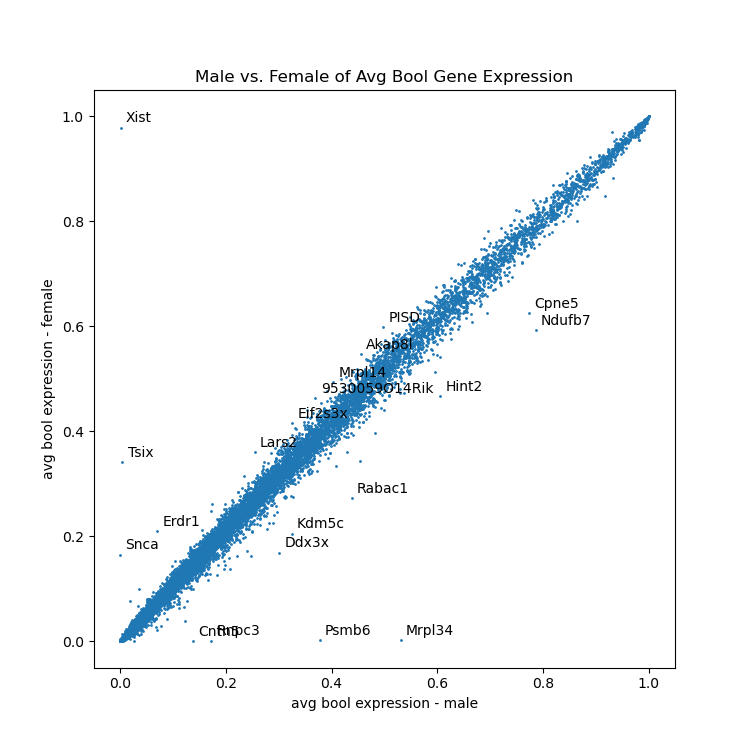

In [197]:
avg_bool_mf_df_sorted_l2 = dp.avg_bool_gene_expression_by_sex(df_bool = dimorph_df_bool_l2,
                                                              meta_data_df=meta_data_df_l2,
                                                             num_top_genes=10)

In [198]:
avg_bool_mf_df_sorted_l2.head()

,m,f,delta_m-f
Xist,0.000911,0.978212,-0.977300
Tsix,0.004304,0.341709,-0.337405
Snca,0.000051,0.164937,-0.164887
Erdr1,0.070485,0.209455,-0.138970
Lars2,0.254342,0.359672,-0.105330
